In [1]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns
import tqdm

import article

In [2]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

In [3]:
re_int = re.compile(r'[0-9]+')

def int_from_dir_path(dir_path):
    name = dir_path.name
    return int(re_int.search(name)[0])

In [4]:
PROJ_ROOT = pyprojroot.here()
RESULTS_ROOT = PROJ_ROOT / 'results' / 'Bengalese_Finches'
SPECT_PARAMS_NO_TRANSFORM_ROOT = RESULTS_ROOT / 'learncurve'
SPECT_PARAMS_LOG_TRANSFORM_ROOT = RESULTS_ROOT / 'spect_params'
FIGS_ROOT  = PROJ_ROOT / 'doc' / 'article' / 'figures'

### Figure

In [5]:
sns.set("paper")

for the main figure, we further tweak the function `article.plot.error_curve.across_animals`

In [6]:
FIGSIZE = (7.5, 3.75)
DPI = 300


def error_across_animals_with_without_cleanup(curve_df, 
                                              cleanup,
                                              cleanup_str,
                                              none_text_xy=(0.5, 0.025),
                                              cleanup_text_xy=(0.5, 0.25),
                                              ax1_ylim=(0, 8),
                                              ax2_ylim=(0.1, 0.65),
                                              suptitle=None,
                                              figsize=FIGSIZE,
                                              dpi=DPI):
    if cleanup not in curve_df.cleanup.unique():
        raise ValueError(
            f'clean-up {cleanup} not found in unique values of '
            f'curve_df cleanup column: {curve_df.cleanup.unique()}'
        )
    TRAIN_DUR_IND_MAP = {
        k:v for k, v in zip(
            sorted(curve_df['train_set_dur'].unique()), 
            sorted(curve_df['train_set_dur_ind'].unique())
        )
    }

    fig = plt.figure(constrained_layout=False, figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(nrows=4, ncols=3, wspace=0.6)

    ax_arr = []
    ax_arr.append(fig.add_subplot(gs[0, 0]))
    ax_arr.append(fig.add_subplot(gs[1:, 0]))
    ax_arr.append(fig.add_subplot(gs[:, 1]))
    ax_arr.append(fig.add_subplot(gs[:, 2]))

    ax_arr = np.asarray(ax_arr)
    ax_arr[0].get_shared_x_axes().join(*ax_arr[:2].tolist())

    #for col in range(2):
    ax_arr[0].spines['bottom'].set_visible(False)
    ax_arr[1].spines['top'].set_visible(False)
    ax_arr[1].xaxis.tick_bottom()

    # ---- set up lists we iterate through to make figure
    metrics = [
        'avg_error', 
        'avg_segment_error_rate',
        'avg_segment_error_rate',
    ]
    cleanups = [
        'none', 
        'none',
        cleanup,
    ]
    ylabels = [
        'Frame error (%)', 
        'Segment error rate\n(edits per segment)', 
        'Segment error rate\n(edits per segment)',
    ]


    for col, (metric, cleanup, ylabel) in enumerate(zip(metrics, cleanups, ylabels)):
        ax = ax_arr[col + 1]  # skip ax_arr[0]

        if col == 2:  # legend only for last column
            legend = 'full'
        else:
            legend = False

        curve_df_cleanup = curve_df[curve_df.cleanup == cleanup]
        sns.lineplot(x='train_set_dur_ind', 
                     y=metric, 
                     hue='animal_id', 
                     data=curve_df_cleanup,
                     ci='sd',
                     palette='colorblind',
                     linewidth=2, 
                     ax=ax, 
                     legend=legend)
        sns.lineplot(x='train_set_dur_ind', 
                     y=metric, 
                     linestyle='dashed', 
                     color='k', 
                     linewidth=4, 
                     data=curve_df_cleanup,
                     ci=None, 
                     label='mean',
                     ax=ax, 
                     legend=legend)

        ax.set_ylabel('')

        ax.set_xlabel('Training set duration (s)', fontsize=10)
        ax.set_xticks(list(TRAIN_DUR_IND_MAP.values()))
        ax.set_xticklabels(sorted(curve_df['train_set_dur'].unique().astype(int)), rotation=45)


    ax_arr[0].set_xticklabels([])
    ax_arr[0].set_xlabel('')

    # zoom-in / limit the view to different portions of the data
    ax_arr[0].set_ylim(40, 100)
    ax_arr[1].set_ylim(ax1_ylim)
    ax_arr[2].set_ylim(ax2_ylim)
    ax_arr[3].set_ylim(ax2_ylim)

    x, y = none_text_xy
    ax_arr[2].text(x, y, 'clean-up:\nnone')
    x, y = cleanup_text_xy
    ax_arr[3].text(x, y, f'clean-up:\n{cleanup_str}')
    
    bigax_col0 = fig.add_subplot(gs[:, 0], frameon=False)
    bigax_col1 = fig.add_subplot(gs[:, 1], frameon=False)
    bigax_col2 = fig.add_subplot(gs[:, 2], frameon=False)
    labelpads = (2, 10, 10)
    panel_labels = ['A', 'B', 'C']
    for ylabel, labelpad, panel_label, ax in zip(ylabels,
                                                 labelpads,
                                                 panel_labels,
                                                 [bigax_col0, bigax_col1, bigax_col2]):
        ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        ax.grid(False)
        ax.set_ylabel(ylabel, fontsize=12, labelpad=labelpad)
        ax.text(-0.3, 1., panel_label, transform=ax.transAxes,
              fontsize=18, fontweight='bold', va='top', ha='right')

    # get handles from right axes legend, then remove and re-create outside
    handles, _ = ax_arr[-1].get_legend_handles_labels()
    [ha.set_linewidth(2) for ha in handles ]
    ax_arr[-1].get_legend().remove()
    bigax_col2.legend(handles=handles, bbox_to_anchor=(1.8, 1))

    if suptitle is not None:
        fig.suptitle(suptitle)
    
    return fig

Load source data, generate figure

In [7]:
SPECT_PARAMS_FIGS_ROOT = fname = FIGS_ROOT / 'results' / 'Bengalese_Finches' / 'spect_params'

### Learning curves generated using spectrograms **without** log transform and thresholding
First we look at results from spectrograms where we do **not** do any transformation (e.g. log transform) or thresholding.
These are the exact same results as in Figure 1, only here we are emphasizing the parameters used to generate spectrograms, to compare with results obtained using a different set of parameters shown below.

In the config files, these parameters look like:

```toml
[SPECT_PARAMS]
fft_size = 512
step_size = 64
```

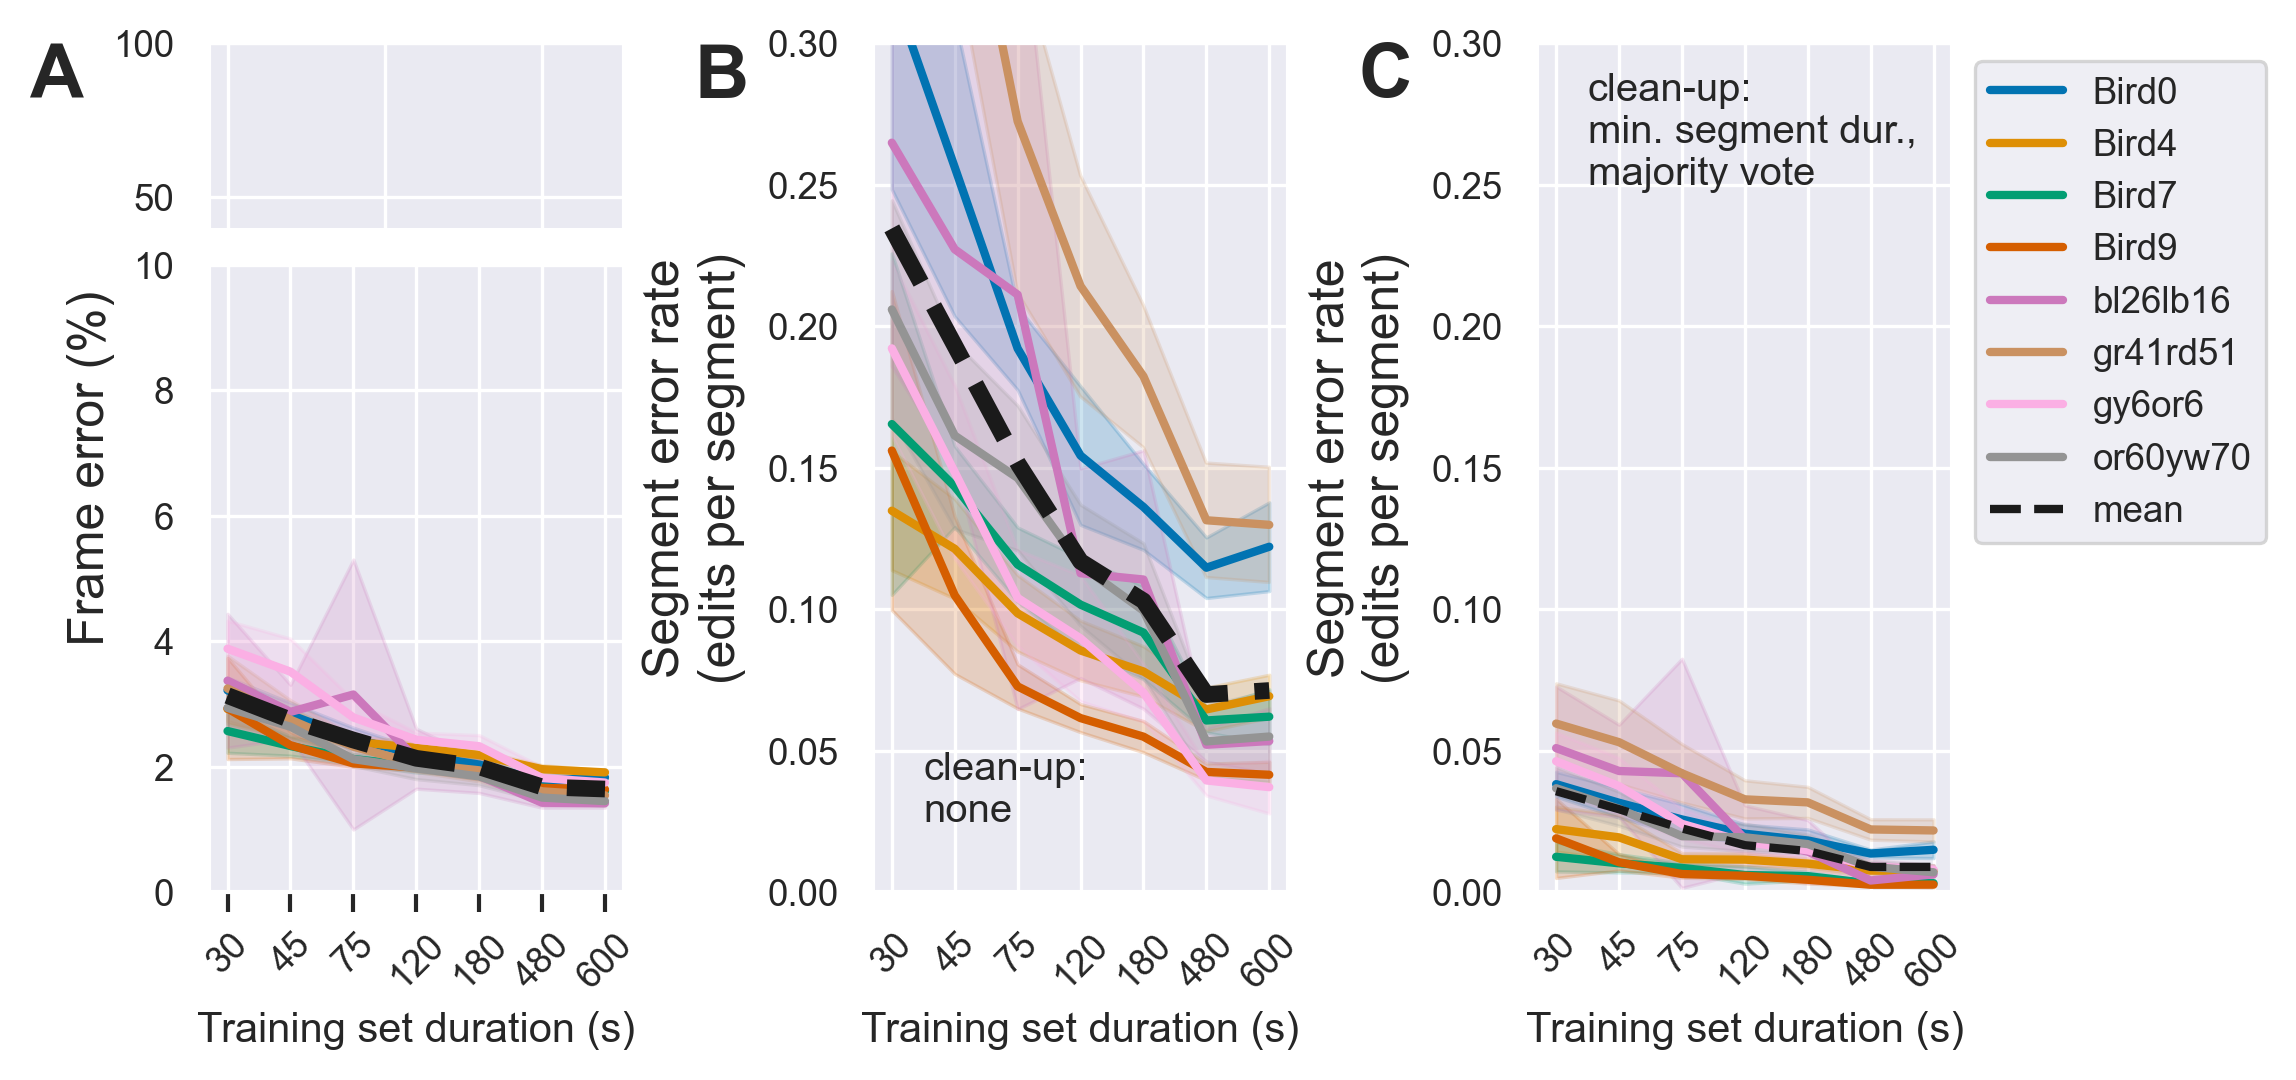

In [9]:
error_csv_path = SPECT_PARAMS_NO_TRANSFORM_ROOT .joinpath('error_across_birds_with_cleanup.csv')
curve_df = pd.read_csv(error_csv_path)
# SPECT_PARAMS_LOG_TRANSFORM_ROOT = RESULTS_ROOT / 'spect_params'

fig = error_across_animals_with_without_cleanup(curve_df,
                                                cleanup='min_segment_dur_majority_vote',
                                                cleanup_str='min. segment dur.,\nmajority vote',
                                                ax1_ylim=(0,10),
                                                ax2_ylim=(0., 0.3))
fig.savefig(
    SPECT_PARAMS_FIGS_ROOT / 'error-curves-without-log-transform-or-thresholding.png'
)
plt.show()

### Learning curves generated using spectrograms **with** log transform and thresholding
Here are results for four of the eight Bengalese finches where a log transform + thresholding **were** applied.

In the config files, these look like:
```toml
[SPECT_PARAMS]
fft_size = 512
step_size = 64
freq_cutoffs = [ 500, 10000,]
thresh = 6.25
transform_type = "log_spect"
```

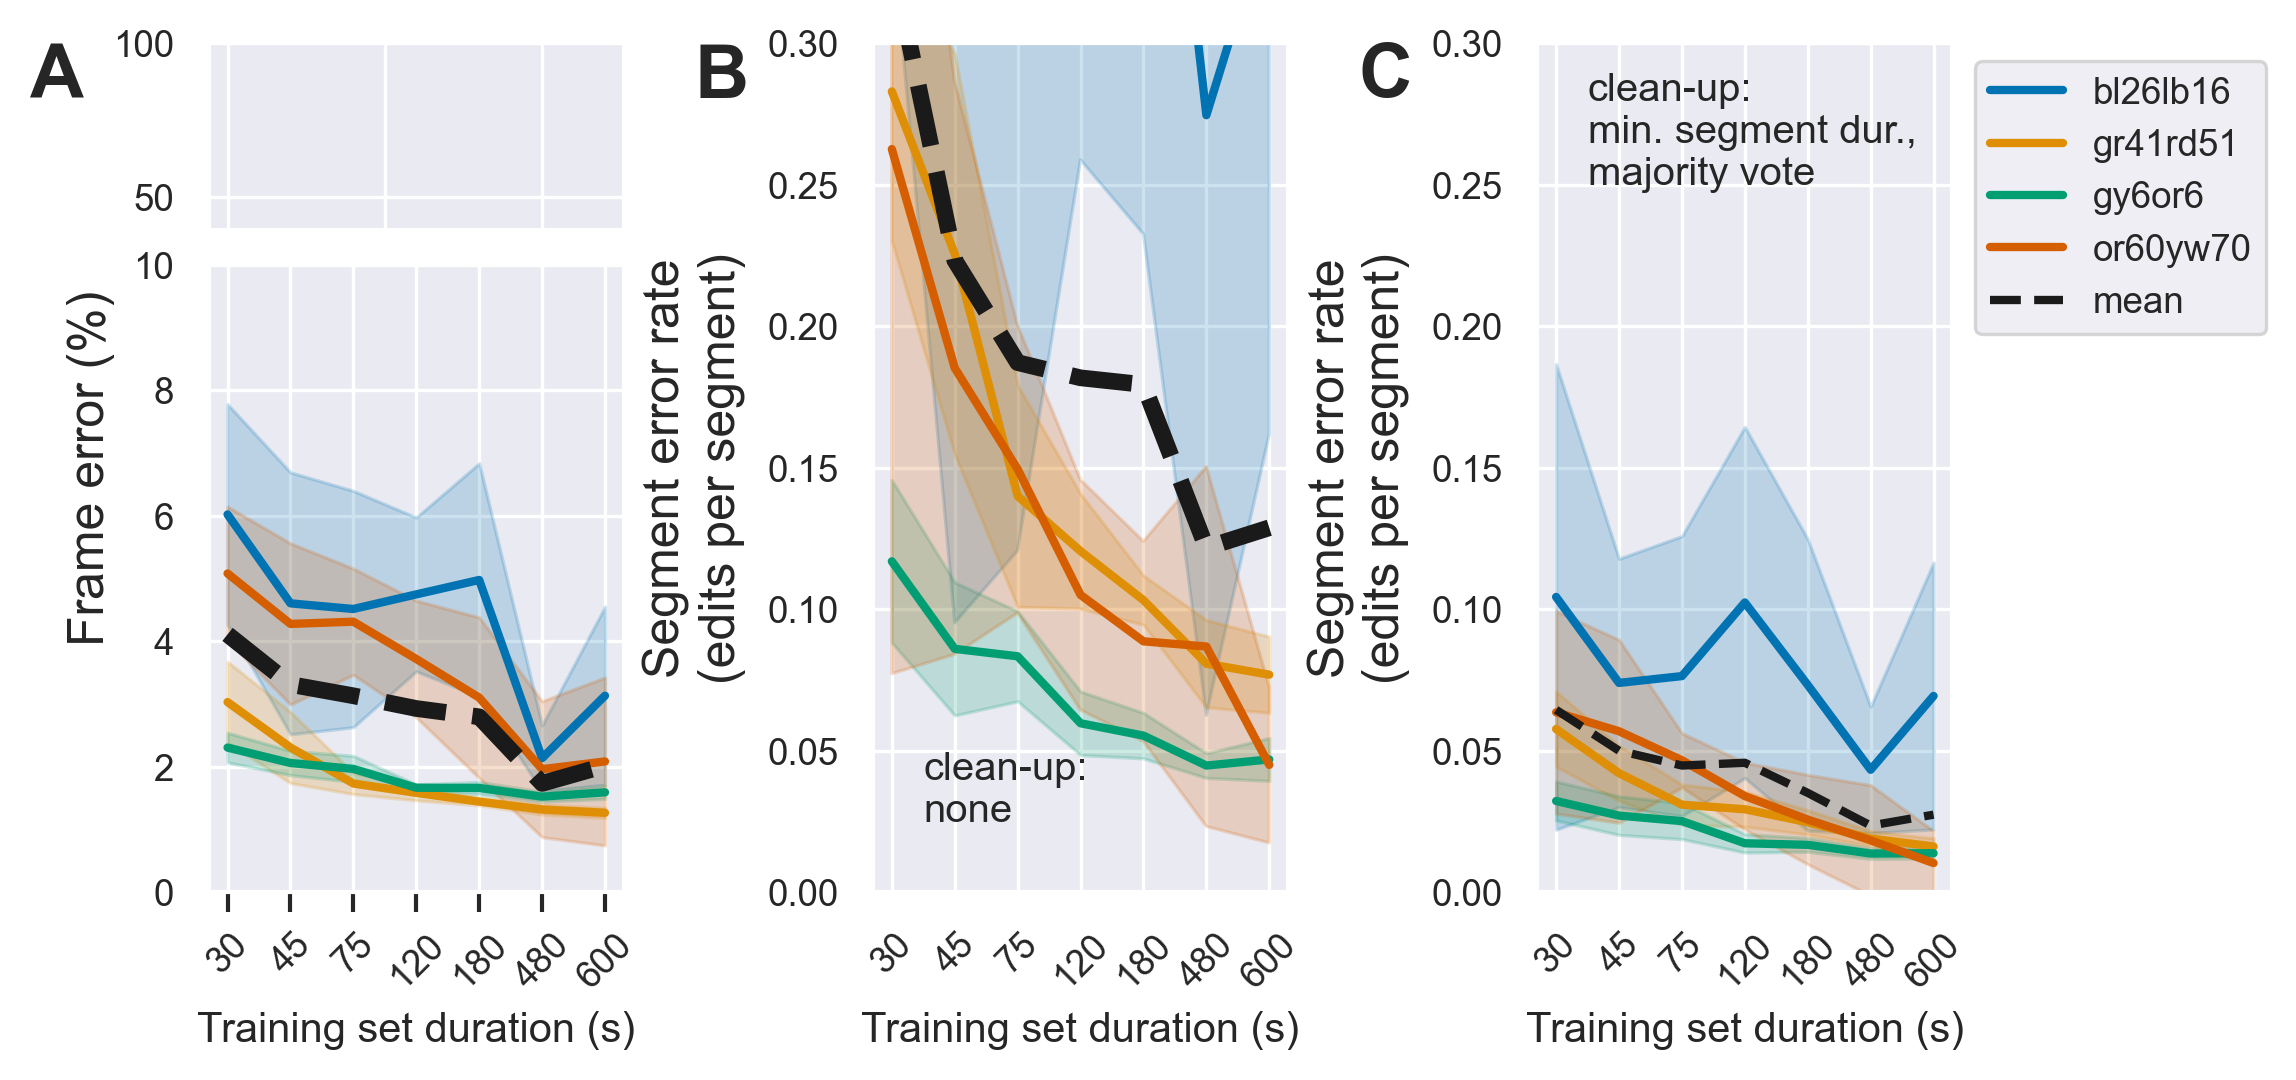

In [10]:
error_csv_path = SPECT_PARAMS_LOG_TRANSFORM_ROOT .joinpath('error_across_birds_with_cleanup.csv')
curve_df = pd.read_csv(error_csv_path)


fig = error_across_animals_with_without_cleanup(curve_df,
                                                cleanup='min_segment_dur_majority_vote',
                                                cleanup_str='min. segment dur.,\nmajority vote',
                                                ax1_ylim=(0,10),
                                                ax2_ylim=(0., 0.3))
fig.savefig(
    SPECT_PARAMS_FIGS_ROOT / 'error-curves-with-log-transform-or-thresholding.png'
)
plt.show()

Here we see that error was much higher for bl26lb16, but relatively unchanged for the other three birds.
Note that values were standardized (zero-centered, unit variance) after applying log transform and thresholding, as is typically done  with training data for neural networks.
So either the log transform or the thresholding affects the input data distribution in such a way that it can impair training in some cases, but not always.
Based on this we conclude that for training it is better to not transform or threshold the spectrograms.